# Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imgaug import augmenters as iaa
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

from utils import read_data_pcas, plot_confusion_matrix

# Read Data
Having just 5 classes of objects, one was extracted to ensure that model generalizes on other objects too.
So we have 4 classes of objects on train and 1 on test 

In [5]:
X_train, y_train, X_test, y_test = read_data_pcas()

100%|██████████| 4/4 [00:27<00:00,  6.94s/it]


# Train Valid Split
For validation select random 15% of images from train, having 4 classes of objects.

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, \
                                                      test_size=0.15, random_state=7)

# Exploratory data analysis
## Listing images size and sanity check for sizes

In [7]:
print("Train examples: %s" % len(X_train))
print("Valid examples: %s" % len(X_valid))
print("Test examples: %s" % len(X_test))
print()

# assert all images have same size
imgs_shape = X_train.shape[1:]
for img in np.concatenate([X_valid, X_test]):
    assert img.shape == imgs_shape
    
print("Images size: %s" % (imgs_shape[1:3],))
print()
print('Channels num: %s' % (imgs_shape[-1]))

Train examples: 7161
Valid examples: 1264
Test examples: 1566

Images size: (227, 3)

Channels num: 3


## Distribution of clases

In [8]:
from collections import Counter

train_c = Counter(y_train)
valid_c = Counter(y_valid)
test_c = Counter(y_test)

As we can see below the distribution is skewed having almost 4000 images for sketch class and just 2000 images for photo 

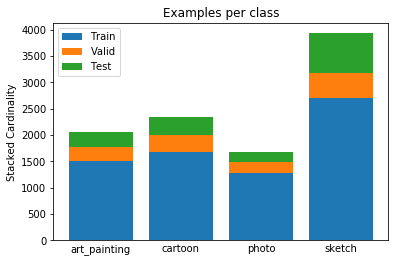

In [9]:
train_keys = sorted(train_c.keys())
plt.bar(train_keys, [train_c[key] for key in train_keys])
plt.bar(train_keys, [valid_c[key] for key in train_keys], \
       bottom = [train_c[key] for key in train_keys])
plt.bar(train_keys, [test_c[key] for key in train_keys], \
       bottom = [train_c[key] + valid_c[key] for key in train_keys])
plt.legend(['Train', 'Valid', "Test"])
plt.ylabel('Stacked Cardinality')
plt.title('Examples per class')
plt.xticks([0,1,2,3], train_keys)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    length=0) # labels along the bottom edge are off

### Examples

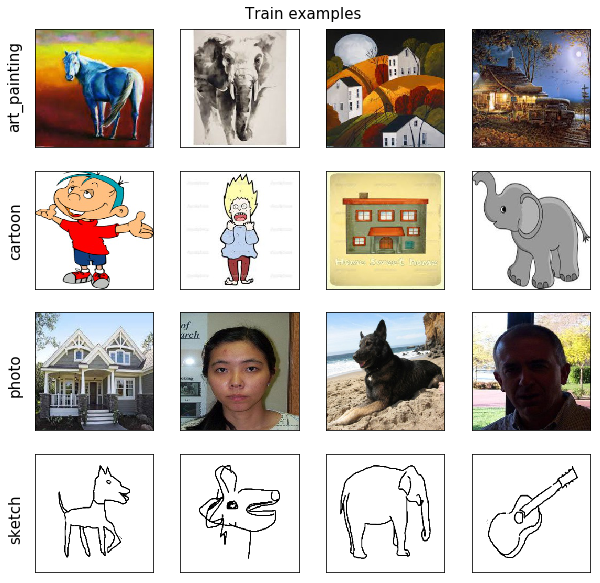

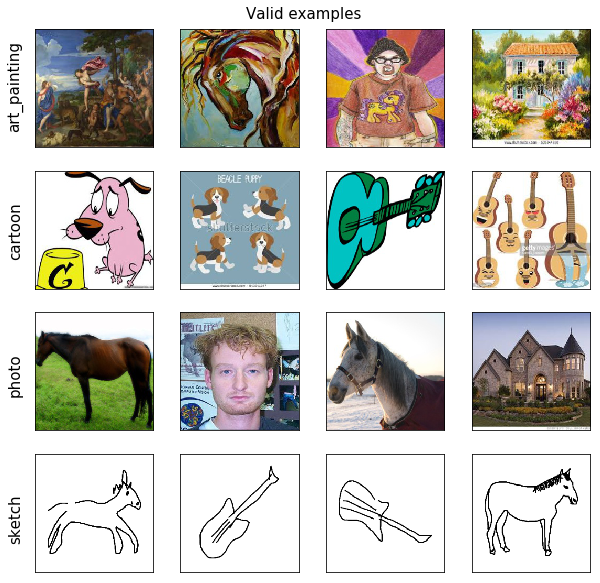

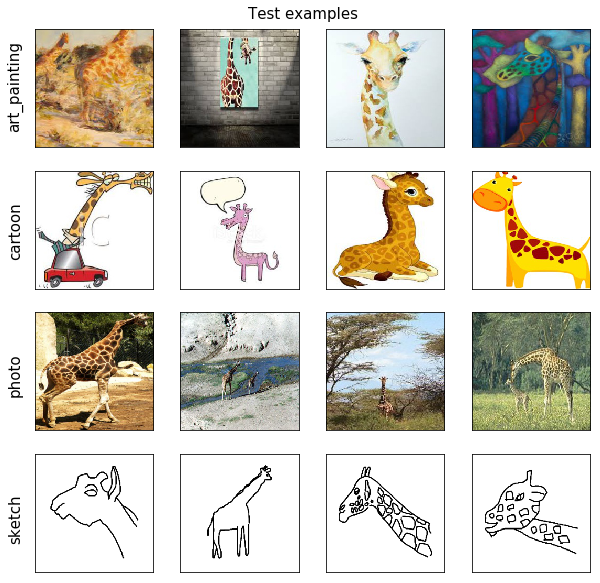

In [10]:
for X, y, case_str in zip([X_train, X_valid, X_test], 
                          [y_train, y_valid, y_test], 
                          ['train', 'valid', 'test']):
    fig = plt.figure(figsize=(10, 10))
    fig.text(0.5, 0.9, "%s examples" % case_str.capitalize(), size=15, ha='center', va='center')
    plt_index = 1
    y_pos = 0.8
    for cs in train_keys:
        class_images = X[y == cs][:4]
        for img in class_images:
            plt.subplot(4, 4, plt_index)
            plt.imshow(img)
            plt.xticks([])
            plt.yticks([])
            plt_index += 1

        fig.text(0.1, y_pos, cs, size=15, ha='center', va='center', rotation='vertical')
        y_pos -= 0.2


# Preprocessing
### Label Encoding

In [11]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_valid = le.transform(y_valid)
y_test = le.transform(y_test)

### Compute class weights based on number of examples per class

In [12]:
c_sum = np.sum(list(train_c.values()))
class_weight = {}
for c, cnt in train_c.items():
    class_weight[le.transform([c])[0]] = c_sum / cnt / 4

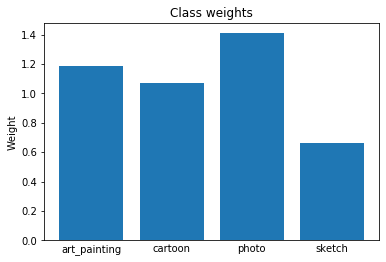

In [13]:
plt.bar(*list(zip(*class_weight.items())))
plt.title("Class weights")
plt.ylabel("Weight")
plt.xticks([0,1,2,3], train_keys)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    length=0) # labels along the bottom edge are off

### Basic Image Generator

In [14]:
basic_data_generator = ImageDataGenerator()
img_gen = basic_data_generator.flow(X_train, y_train, batch_size=32)

### Augmented Image Generator

In [23]:
train_aug = iaa.Sequential([
    iaa.Affine(rotate=(-180, 180)),
    iaa.Crop(percent=(0, 0.25))    
])

augmented_data_generator = ImageDataGenerator(preprocessing_function=train_aug.augment_image)
img_aug_gen = augmented_data_generator.flow(X_train, y_train, batch_size=32)

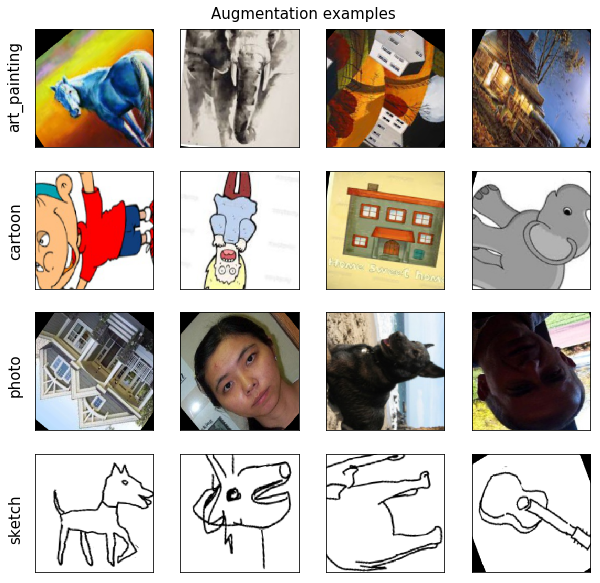

In [24]:
fig = plt.figure(figsize=(10, 10))
fig.text(0.5, 0.9, "Augmentation examples", size=15, ha='center', va='center')
plt_index = 1
y_pos = 0.8
for cs in le.transform(train_keys):
    aug_class_images = train_aug.augment_images(X_train[y_train == cs][:4])
    for img in aug_class_images:
        plt.subplot(4, 4, plt_index)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt_index += 1

    fig.text(0.1, y_pos, le.classes_[cs], size=15, ha='center', va='center', rotation='vertical')
    y_pos -= 0.2

# Modeling

In [15]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Conv2D, \
        GlobalAveragePooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.applications.resnet50 import ResNet50
from keras.applications.mobilenet import MobileNet
from keras.preprocessing.image import ImageDataGenerator

## Dense Basic Model

In [16]:
np.random.seed(7)

model = Sequential()
model.add(Flatten(input_shape=X_train.shape[1:]))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(4))
model.add(Activation('softmax'))

model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

In [17]:
model.fit_generator(img_gen, steps_per_epoch=50, validation_data=(X_valid, y_valid), \
                        epochs=25, class_weight=class_weight)

Epoch 1/25
50/50 [==============================] - 7s 150ms/step - loss: 11.8799 - sparse_categorical_accuracy: 0.2250 - val_loss: 12.8664 - val_sparse_categorical_accuracy: 0.2017
Epoch 2/25
50/50 [==============================] - 6s 126ms/step - loss: 11.8347 - sparse_categorical_accuracy: 0.2219 - val_loss: 12.8664 - val_sparse_categorical_accuracy: 0.2017
Epoch 3/25
50/50 [==============================] - 7s 132ms/step - loss: 12.3514 - sparse_categorical_accuracy: 0.2008 - val_loss: 12.8664 - val_sparse_categorical_accuracy: 0.2017
Epoch 4/25
50/50 [==============================] - 6s 124ms/step - loss: 12.0340 - sparse_categorical_accuracy: 0.2125 - val_loss: 12.8664 - val_sparse_categorical_accuracy: 0.2017
Epoch 5/25
50/50 [==============================] - 6s 128ms/step - loss: 12.3165 - sparse_categorical_accuracy: 0.1931 - val_loss: 12.8664 - val_sparse_categorical_accuracy: 0.2017
Epoch 6/25
50/50 [==============================] - 6s 123ms/step - loss: 12.0575 - sparse

In [18]:
model.evaluate(X_test, y_test)

1566/1566 [==============================] - 2s 1ms/step


[13.184725614038607, 0.18199233716475097]

#### Results (Acc)
- Train: 21.5% 
- Valid: 20.1%
- Test: 18.1%

#### Profiling (GPU colab K80)
- Train Time: 5 s/epoch
- Time: 0.94 us/step (CPU local)

## Convolutional Model

In [23]:
np.random.seed(7)

model = Sequential()
model.add(Conv2D(64, (3,3), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(4))
model.add(Activation('softmax'))

model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

In [ ]:
model.fit_generator(img_gen, steps_per_epoch=50, validation_data=(X_valid, y_valid), \
                        epochs=25, class_weight=class_weight)

In [ ]:
model.evaluate(X_test, y_test)

#### Results (Acc)
- Train: 21 % 
- Valid: 20 %
- Test: 16 %

#### Profiling (GPU colab K80)
- Train Time: 43 s/epoch
- Time: 7 ms/step 

## Mobile Net

### Random Init

In [ ]:
np.random.seed(7)

base_model = MobileNet(input_shape=X_train.shape[1:], weights=None, \
                       include_top=False, dropout=0.2)

# adding top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

In [ ]:
model.fit_generator(img_gen, steps_per_epoch=50, validation_data=(X_valid, y_valid), \
                        epochs=25, class_weight=class_weight)

In [ ]:
model.evaluate(X_test, y_test)

#### Results (Acc)
- Train: 87%
- Valid: 75%
- Test: 73%

#### Profiling (GPU colab K80)
- Train Time: 30 s/epoch
- Inference Time: 5 ms/example (GPU colab K80)

### Pretrained on ImageNet

In [ ]:
np.random.seed(7)

base_model = MobileNet(input_shape=X_train.shape[1:], weights='imagenet', \
                       include_top=False, dropout=0.2)

# adding top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

In [ ]:
model.fit_generator(img_gen, steps_per_epoch=50, validation_data=(X_valid, y_valid), \
                        epochs=25, class_weight=class_weight)

In [ ]:
model.evaluate(X_test, y_test)

#### Results (Acc)
- Train: 99.9%
- Valid: 98.8%
- Test: 95.1%

#### Profiling (GPU colab K80)
- Train Time: 30 s/epoch
- Inference Time: 5 ms/example (GPU colab K80)

### Image Augmentation

In [ ]:
np.random.seed(7)

base_model = MobileNet(input_shape=X_train.shape[1:], weights='imagenet', \
                       include_top=False, dropout=0.2)

# adding top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

In [ ]:
model.fit_generator(img_aug_gen, steps_per_epoch=50, validation_data=(X_valid, y_valid), \
                        epochs=25, class_weight=class_weight)

In [ ]:
model.evaluate(X_test, y_test)

#### Results (Acc)
- Train: 97.2%
- Valid: 96.9%
- Test: 96.2%

#### Profiling (GPU colab K80)
- Train Time: 30 s/epoch
- Inference Time: 5 ms/example (GPU colab K80)

### Combined

In [ ]:
np.random.seed(7)

base_model = MobileNet(input_shape=X_train.shape[1:], weights='imagenet', \
                       include_top=False, dropout=0.2)

# adding top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

In [ ]:
model.fit_generator(img_gen, steps_per_epoch=50, validation_data=(X_valid, y_valid), \
                        epochs=10, class_weight=class_weight)
model.fit_generator(img_aug_gen, steps_per_epoch=50, validation_data=(X_valid, y_valid), \
                        epochs=30, class_weight=class_weight)

In [ ]:
model.evaluate(X_test, y_test)

#### Results (Acc)
- Train: 98%
- Valid: 97.2%
- Test: 94.4%

#### Profiling (GPU colab K80)
- Train Time: 30 s/epoch
- Inference Time: 5 ms/example (GPU colab K80)

## ResNet50

### Without image augmentation

In [ ]:
base_model = ResNet50(input_shape=X_train.shape[1:], weights='imagenet', \
                       include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
predictions = Dense(4, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

In [ ]:
model.fit_generator(img_gen, steps_per_epoch=50, validation_data=(X_valid, y_valid), \
                        epochs=10, class_weight=class_weight)

In [ ]:
model.evaluate(X_test, y_test)

#### Results (Acc)
- Train: 98.3%
- Valid: 96.5%
- Test: 93.7%

#### Profiling (GPU colab K80)
- Train Time: 60 s/epoch
- Inference Time: 5 ms/example (GPU colab K80)

### Adding augmentation

In [ ]:
base_model = ResNet50(input_shape=X_train.shape[1:], weights='imagenet', \
                       include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
predictions = Dense(4, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

In [ ]:
model.fit_generator(img_gen, steps_per_epoch=50, validation_data=(X_valid, y_valid), \
                        epochs=10, class_weight=class_weight)

In [ ]:
model.evaluate(X_test, y_test)

#### Results (Acc)
- Train: 97.8%
- Valid: 95%
- Test: 92.6%

#### Profiling (GPU colab K80)
- Train Time: 60 s/epoch
- Inference Time: 5 ms/example (GPU colab K80)

# Agregate Results

In [21]:
model_names = ['dense', 'conv', 'mobile_net_rand', 'mobile_net', 'mobile_net_aug', \
               'mobile_net_comb', 'resnet', 'resnet_aug']
train_results = [21.5, 21, 87, 99.7, 97.2, 98, 98.3, 97.8]
valid_results = [20.1, 20, 75, 98.8, 96.9, 97.2, 96.5, 95.5]
test_results = [18.1, 16, 73, 95.1, 96.2, 94.4, 93.7, 92.6]

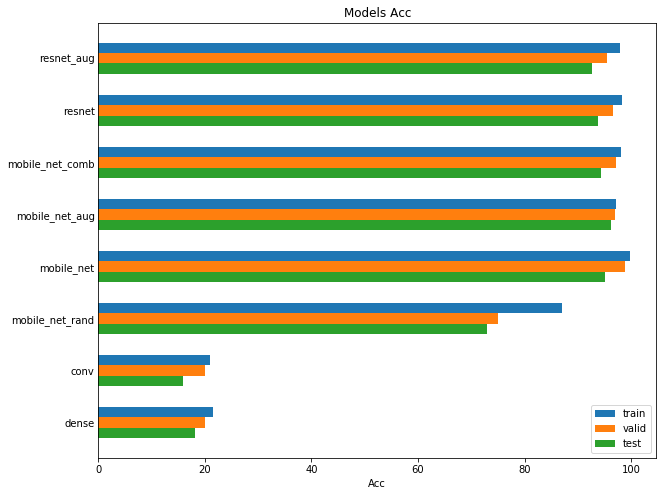

In [22]:
plt.figure(figsize=(10, 8))
plt.barh(list(map(lambda x: x + 0.2, range(len(model_names)))), train_results, height=0.2)
plt.barh(range(len(model_names)), valid_results, height=0.2)
plt.barh(list(map(lambda x: x - 0.2, range(len(model_names)))), test_results, height=0.2)
plt.legend(["train", "valid", "test"])
plt.title("Models Acc")
plt.xlabel("Acc")
plt.yticks(range(len(model_names)), model_names)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    length=0) # labels along the bottom edge are off

# Confusion Matrix

In [ ]:
y_hat_test = np.argmax(model.predict(X_test), axis=1)
y_hat_valid = np.argmax(model.predict(X_valid), axis=1)

conf_mat_test = confusion_matrix(y_test, y_hat_test)
conf_mat_valid = confusion_matrix(y_valid, y_hat_valid)

plt.figure()
plot_confusion_matrix(conf_mat_test, classes=train_keys, normalize=True,
                      title='Normalized Confusion Matrix on Test')

plt.figure()
plot_confusion_matrix(conf_mat_valid, classes=train_keys, normalize=True,
                      title='Normalized Confusion Matrix on Valid')

# Misclassification examples

In [ ]:
fig = plt.figure(figsize=(15, 10))
fig.text(0.5, 0.92, "Misclassification examples", size=15, ha='center', va='center')
plt_index = 1
for img, true, pred in zip(X_test[y_hat_test != y_test], \
                        y_test[y_hat_test != y_test], \
                        y_hat_test[y_hat_test != y_test]):
    plt.subplot(4, 4, plt_index)
    plt.title("True: %s Predicted: %s" % (le.classes_[true], le.classes_[pred]))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt_index += 1
    if plt_index > 16:
        break